**Author:** Boris Kundu

**Problem Statement:** Telecom customer churn prediction by using machine learning models for classification.

**Dataset:** https://www.kaggle.com/datasets/blastchar/telco-customer-churn

In [38]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [39]:
# Read data
tc = pd.read_csv('Telco-Customer-Churn.csv')
pd.options.mode.chained_assignment = None  # default='warn'

In [40]:
# Check 5 samples
tc.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [41]:
# Check data model
tc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [42]:
# Check stats
tc.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


**Exploratory Data Analysis**

In [43]:
# Removing data points with tenure = 0
tc = tc[tc['tenure'] > 0]

In [44]:
# Convert TotalCharges to float
tc['TotalCharges'] = tc.TotalCharges.astype(float)

In [45]:
#Check for null values
tc.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [46]:
# Categorical features
categFeat = ['gender', 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod','Churn']

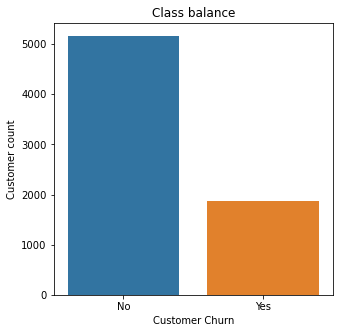

In [47]:
#Check target 'Churn' feature balance
plt.figure(figsize=(5,5))
sns.countplot(data=tc,x='Churn')
plt.title('Class balance')
plt.ylabel('Customer count')
plt.xlabel('Customer Churn')
plt.show()

In [48]:
# Get categorical feature correlation with Churn
tc_corr = pd.get_dummies(tc[categFeat]).corr()

In [49]:
# Check corelation
tc_corr.head()

,SeniorCitizen,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,...,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_No,Churn_Yes
SeniorCitizen,1.000000,0.001819,-0.001819,-0.016957,0.016957,0.210550,-0.210550,-0.008392,0.008392,-0.136377,...,-0.046491,-0.116205,-0.156258,0.156258,-0.016235,-0.024359,0.171322,-0.152987,-0.150541,0.150541
gender_Female,0.001819,1.000000,-1.000000,-0.001379,0.001379,0.010349,-0.010349,-0.007515,0.007515,-0.004335,...,-0.007755,0.003603,-0.011902,0.011902,0.015973,-0.001632,-0.000844,-0.013199,-0.008545,0.008545
gender_Male,-0.001819,-1.000000,1.000000,0.001379,-0.001379,-0.010349,0.010349,0.007515,-0.007515,0.004335,...,0.007755,-0.003603,0.011902,-0.011902,-0.015973,0.001632,0.000844,0.013199,0.008545,-0.008545
Partner_No,-0.016957,-0.001379,0.001379,1.000000,-1.000000,0.452269,-0.452269,0.018397,-0.018397,0.130028,...,-0.083067,-0.247334,-0.013957,0.013957,-0.111406,-0.082327,0.083207,0.096948,-0.149982,0.149982
Partner_Yes,0.016957,0.001379,-0.001379,-1.000000,1.000000,-0.452269,0.452269,-0.018397,0.018397,-0.130028,...,0.083067,0.247334,0.013957,-0.013957,0.111406,0.082327,-0.083207,-0.096948,0.149982,-0.149982


In [50]:
# Get correlation for Churned customers and exclude Churn categories
tc_corr['Churn_Yes'].sort_values(ascending=False)[1:-1]

Contract_Month-to-month                    0.404565
OnlineSecurity_No                          0.342235
TechSupport_No                             0.336877
InternetService_Fiber optic                0.307463
PaymentMethod_Electronic check             0.301455
OnlineBackup_No                            0.267595
DeviceProtection_No                        0.252056
PaperlessBilling_Yes                       0.191454
Dependents_No                              0.163128
SeniorCitizen                              0.150541
Partner_No                                 0.149982
StreamingMovies_No                         0.130920
StreamingTV_No                             0.128435
StreamingTV_Yes                            0.063254
StreamingMovies_Yes                        0.060860
MultipleLines_Yes                          0.040033
PhoneService_Yes                           0.011691
gender_Female                              0.008545
gender_Male                               -0.008545
PhoneService

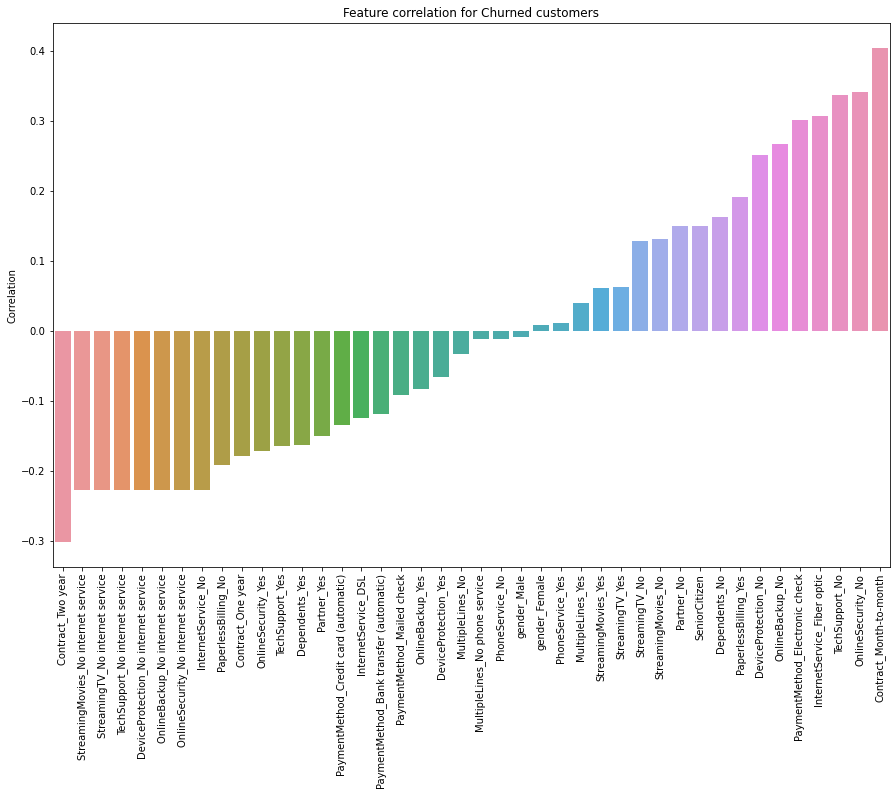

In [51]:
# Show correlation for Churned customers
plt.figure(figsize=(15,10))
sns.barplot(x=tc_corr['Churn_Yes'].sort_values()[1:-1].index, y=tc_corr['Churn_Yes'].sort_values()[1:-1].values)
plt.xticks(rotation=90)
plt.ylabel('Correlation')
plt.title('Feature correlation for Churned customers')
plt.show()

**Churn Analysis**

In [52]:
# Find churn rate by tenure length
no_churn = tc.groupby(by=['Churn','tenure']).count().T['No']
yes_churn = tc.groupby(by=['Churn','tenure']).count().T['Yes']
churn_rate = (yes_churn)/(yes_churn+no_churn)*100
churn_rate.T['customerID']

tenure
1     61.990212
2     51.680672
3     47.000000
4     47.159091
5     48.120301
        ...    
68     9.000000
69     8.421053
70     9.243697
71     3.529412
72     1.657459
Name: customerID, Length: 72, dtype: float64

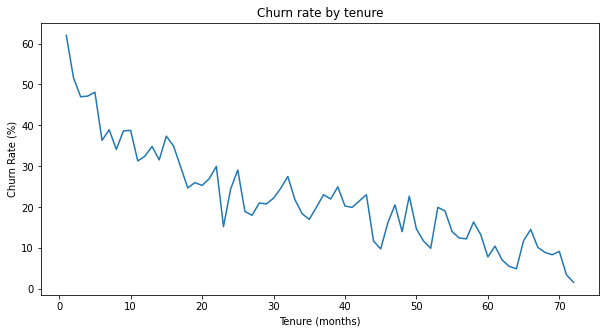

In [53]:
plt.figure(figsize = (10,5))
plt.plot(churn_rate.T['customerID'])
plt.ylabel('Churn Rate (%)')
plt.xlabel('Tenure (months)')
plt.title('Churn rate by tenure')
plt.show()

In [54]:
#Create tenure categories
def groupTenure(tenure):
    if tenure < 13:
        return 'Upto 1 year'
    elif tenure < 25:
        return '1 to 2 years'
    elif tenure < 49:
        return '2 to 4 years'
    else:
        return "More than 4 years"

In [55]:
# Create feature TenureGroup
tc['TenureGroup'] = tc['tenure'].apply(groupTenure)

<Figure size 720x360 with 0 Axes>

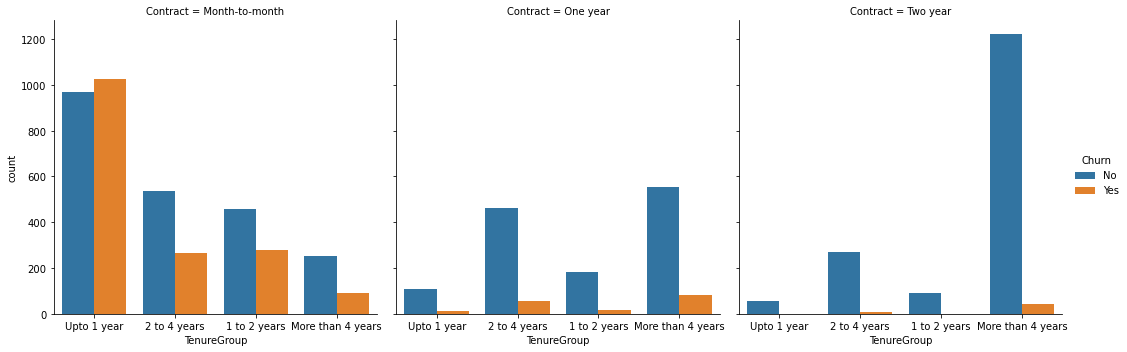

In [56]:
# Check count per TenureGroup, separated by contract type and colored by Churn
plt.figure(figsize=(10,5))
sns.catplot(data=tc,x='TenureGroup',col='Contract', hue='Churn',kind='count')
plt.show()

**Predictive Modeling**

In [57]:
# Prep input features
tc = tc.reset_index(drop=True)
features = tc.drop(['customerID','TenureGroup','Churn'],axis=1)
categFeat.remove('Churn')

In [58]:
# Encode categorical features
featuresCat = pd.get_dummies(features[categFeat])

In [59]:
# Scale numerical_features
mms = MinMaxScaler()
featuresNum = features.drop(categFeat,axis=1)
featuresNum = pd.DataFrame(mms.fit_transform(featuresNum),columns = featuresNum.columns)

In [60]:
# Deine training features and target class
features = pd.concat([featuresCat,featuresNum],axis=1)
target = tc['Churn']

In [61]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features,target,test_size=0.3, random_state = 87)

**K-Nearest Neighbors Classifier**

In [62]:
# Define pipeline and parameters
knnPipe = Pipeline([('knn', KNeighborsClassifier())])
knnParams = [{'knn__n_neighbors': range(3,10),'knn__weights': ['uniform', 'distance']}]

In [63]:
# Hyperparameter tuning using GridSearchCV
gsKnn = GridSearchCV(estimator = knnPipe, param_grid = knnParams, scoring = 'accuracy',cv=5, verbose = 1)
KNN = gsKnn.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


In [64]:
# Function for parameter tuning
def parameterTuning(gs,modelName):
    # Get best params
    bestParams = gs.best_params_
    print(f'Best {modelName} Params:\n{bestParams}')
    # Get best score
    bestScore = gs.best_score_
    print(f'Best {modelName} Score:\n{bestScore}')
    # Get top 5 results
    gsResults = pd.DataFrame(gs.cv_results_)
    print(f"Top 5 {modelName} Results:\n{gsResults[['rank_test_score', 'mean_test_score','params']].sort_values(by = ['rank_test_score'])[:5]}")
    # Return best model
    bestModel = gs.best_estimator_
    return bestModel

In [65]:
# Function to predict and evaluate model
def predict(model,modelName,target,features):
    # Predict target class
    predictions = model.predict(features)
    print(f'{modelName} Accuracy Score:{accuracy_score(target, predictions)}')
    # Model Evaluation
    print(f'{modelName} Classification Report:\n{classification_report(target, predictions)}')
    # Plot confusion matrix
    plt.figure(figsize=(8,4))
    ConfusionMatrixDisplay.from_predictions(target,predictions,cmap = 'Greens')
    plt.title(f'{modelName} Confusion Matrix')
    plt.show()

In [66]:
# Best KNN model
bestKnnModel = parameterTuning(KNN,'KNN')

Best KNN Params:
{'knn__n_neighbors': 8, 'knn__weights': 'uniform'}
Best KNN Score:
0.7791562461309892
Top 5 KNN Results:
    rank_test_score  mean_test_score  \
10                1         0.779156   
12                2         0.773873   
6                 3         0.771638   
8                 4         0.770824   
2                 5         0.768181   

                                               params  
10  {'knn__n_neighbors': 8, 'knn__weights': 'unifo...  
12  {'knn__n_neighbors': 9, 'knn__weights': 'unifo...  
6   {'knn__n_neighbors': 6, 'knn__weights': 'unifo...  
8   {'knn__n_neighbors': 7, 'knn__weights': 'unifo...  
2   {'knn__n_neighbors': 4, 'knn__weights': 'unifo...  


KNN Accuracy Score:0.7554502369668247
KNN Classification Report:
              precision    recall  f1-score   support

          No       0.81      0.86      0.84      1530
         Yes       0.57      0.47      0.51       580

    accuracy                           0.76      2110
   macro avg       0.69      0.67      0.67      2110
weighted avg       0.74      0.76      0.75      2110



<Figure size 576x288 with 0 Axes>

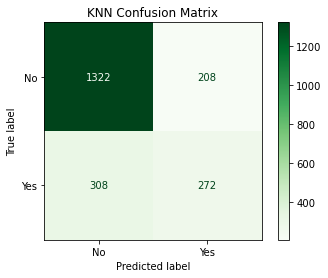

In [67]:
# Best KNN model predictions
predict(bestKnnModel,'KNN',y_test,X_test)

**Decision Tree Classifier**

In [68]:
# Define pipeline and parameters
dtPipe = Pipeline([('dt', DecisionTreeClassifier())])
dtParams = [{'dt__criterion': ['gini','entropy'],'dt__max_depth': range(3,10)}]

In [69]:
# Hyperparameter tuning using GridSearchCV
gsDt = GridSearchCV(estimator = dtPipe, param_grid = dtParams, scoring = 'accuracy',cv=5, verbose = 1)
DT = gsDt.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


In [70]:
# Best DT model
bestDtModel = parameterTuning(DT,'DT')

Best DT Params:
{'dt__criterion': 'entropy', 'dt__max_depth': 5}
Best DT Score:
0.7984563162890512
Top 5 DT Results:
    rank_test_score  mean_test_score  \
9                 1         0.798456   
10                2         0.798254   
2                 3         0.795815   
3                 4         0.791548   
11                5         0.790329   

                                              params  
9   {'dt__criterion': 'entropy', 'dt__max_depth': 5}  
10  {'dt__criterion': 'entropy', 'dt__max_depth': 6}  
2      {'dt__criterion': 'gini', 'dt__max_depth': 5}  
3      {'dt__criterion': 'gini', 'dt__max_depth': 6}  
11  {'dt__criterion': 'entropy', 'dt__max_depth': 7}  


DT Accuracy Score:0.7838862559241706
DT Classification Report:
              precision    recall  f1-score   support

          No       0.82      0.90      0.86      1530
         Yes       0.65      0.47      0.54       580

    accuracy                           0.78      2110
   macro avg       0.73      0.69      0.70      2110
weighted avg       0.77      0.78      0.77      2110



<Figure size 576x288 with 0 Axes>

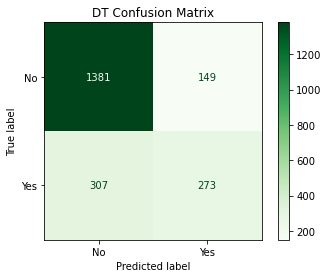

In [71]:
# Best KNN model predictions
predict(bestDtModel,'DT',y_test,X_test)

In [72]:
# Create model using best parameters
dt_model = DecisionTreeClassifier(criterion= 'entropy', max_depth=5)
dt_model.fit(X_train,y_train)
# Get important features
imp_feats = pd.DataFrame(data=dt_model.feature_importances_,index=features.columns,columns=['Significance']).sort_values("Significance")

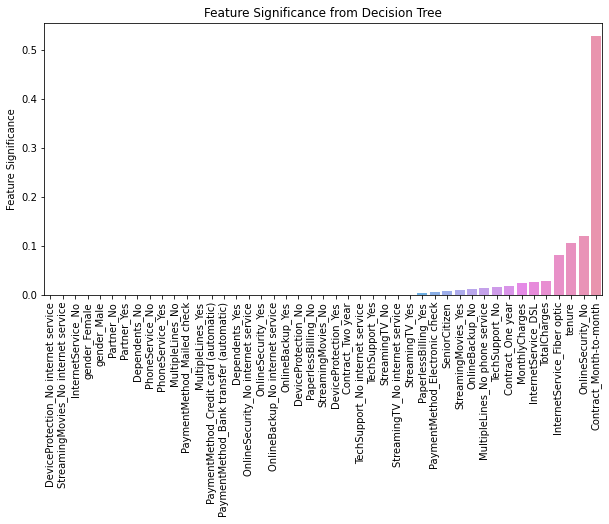

In [73]:
# Plot significance
plt.figure(figsize=(10,5))
sns.barplot(data=imp_feats.sort_values('Significance'),x=imp_feats.sort_values('Significance').index,y='Significance')
plt.xticks(rotation=90)
plt.ylabel('Feature Significance')
plt.title("Feature Significance from Decision Tree")
plt.show()

In [74]:
# Plot Tree
plt.figure(figsize=(20,10),dpi=720)
plot_tree(dt_model,filled=True,feature_names=features.columns)
plt.title('Tree Plot')
plt.show()